## Demo Notebook: How to run the MagAO-X model (with pre-set surface WFE)
This notebook assumes you have the full uncropped PSD WFE pre-calculated for the n0s0 randomizer seed set and saved somewhere you can access them.

Note that the PSD WFE files used in this notebook are not hosted on github. Please go to the `magaox_model_buildWFE.ipynb` notebook to generate your own.

In [1]:
import numpy as np
from astropy import units as u
from astropy.io import fits
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib

# need to look up which version
import pickle

# the only thing you need from my code
from model_kit import magaoxFunctions as mf

Run a version of POPPY no newer than 0.9.2 or after March 1, 2021. The newer version of POPPY has a sign change for OPD to match with ZEMAX. To match the modeling, use a version older than that.

In [2]:
import poppy
poppy.__version__

'0.9.2.dev11+g1887dd5'

Load up all the parameters and file locations

In [3]:
# declare MagAO-X variables
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01, # vAPP leakage multiplier
           'bump': True, # T/F to use the MagAO-X pupil with tweeter bump masked
           'wfe_data': 'allopd'} # other options: common

# set up prescription details, this is important for labeling later.
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # Change this for your own MagAO-X repository
data_dir = home_dir + 'data/'
rx_dir = data_dir + 'rxCSV/'

# load the CSV prescription values
rx_loc = rx_dir+'rx_magaox_NCPDM_sci_{0}_noap_{1}_openfits.csv'.format(parm_name, fr_parm['wfe_data'])
rx_sys = mf.makeRxCSV(rx_loc, print_names=False)

If you want to rename a file or folder for a specific optic to look at a different spot than what is listed in the rxCSV file, here's a quick trick. This is really useful for the Tweeter and vAPP.

In [5]:
# Tweeter index number in the rxCSV (particularly the Optical_Element_Number value)
j_tweeter = 16

# Rename the folder and filename for the pre-solved Tweeter surface
rx_sys[j_tweeter]['surf_PSD_folder'] = 'data/wfemap/tweeter_opd_map/allopd/n{0}/'.format(n_set)
rx_sys[j_tweeter]['surf_PSD_filename'] = 'dm_opd_s{0}_i4'.format(s_set)

In [6]:
# We need to rename all the folder location for the PSD WFE surfaces
# In theory, you can skip this if your rxCSV file has this fixed. (it's not in this file)
# This left here for being able to switch with different PSD WFE sets.

# Setting the folder name
n_set = 0
s_set = 0
psd_wfe_dir = 'data/PSD_WFE/n{0}/s{0}/'.format(n_set, s_set) # Change this for what you want, and make the folder too.

# Quick renaming of the folders 
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['surf_PSD_filename'][0:7] == 'wfe_psd':
        test_opt['surf_PSD_folder'] = psd_wfe_dir

Build the MagAO-X FresnelOpticalSystem.

In [7]:
# build the FresnelOpticalSystem
magaox = mf.csvFresnel(rx_csv=rx_sys, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])

Calculate the PSF.

Note: The `[0]` at the end is there for a quick shortcut, since the `sci_psf` variable is in FITS format.

In [8]:
%%time
sci_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]

CPU times: user 1min 6s, sys: 12.1 s, total: 1min 18s
Wall time: 32.7 s


If you want to see the wavefront at the very end, you can change up the parameters for `calc_psf` to include `return_final=True`.

In [9]:
%%time
sci_psf, sci_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value,
                                  return_final = True)

CPU times: user 1min 7s, sys: 12.3 s, total: 1min 19s
Wall time: 33.5 s


In [10]:
sci_psf[0].header[0:19]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2152                                                  
NAXIS2  =                 2152                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 6.56000000000000E-07 / Weighted mean wavelength in meters             
DIFFLMT =  0.02081687890739926 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL= 1.12834822247980E-05 / Pixel scale in meters/pixel                    
DIAM    =                  6

Let's look at the PSF and the wavefront. They are set to the oversampled matrix, so they are 2152x2152 matrices (538 x 4). You don't need the stuff outside the sample region, so I recommend cropping to only the central 538x538 region.

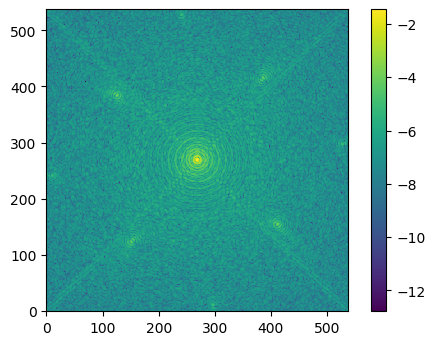

In [11]:
psf_crop = poppy.utils.pad_or_crop_to_shape(sci_psf[0].data, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(np.log10(psf_crop), origin='lower')
plt.colorbar()

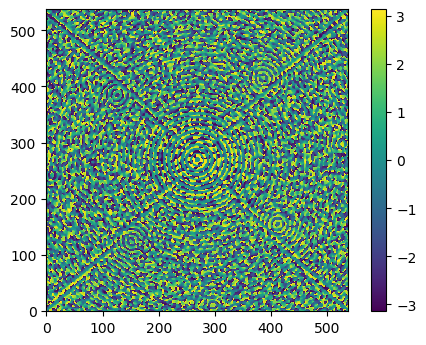

In [12]:
phase_crop = poppy.utils.pad_or_crop_to_shape(sci_wf[0].phase, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow((phase_crop), origin='lower')
plt.colorbar()

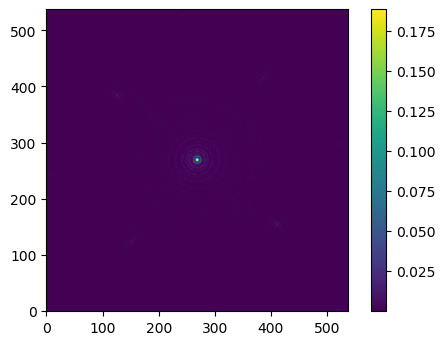

In [13]:
amp_crop = poppy.utils.pad_or_crop_to_shape(sci_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow((amp_crop), origin='lower')
plt.colorbar()

Saving the wavefronts is as simple as how you'd normally save a FITS file. I recommend saving the cropped version because it takes up less space.

In [14]:
sci_hdr = fits.Header()
for cn in range(6, 14): # specifically chosen from POPPY's headers
    card_tuple = sci_wf[0].as_fits('phase')[0].header._cards[cn]
    card_name = card_tuple[0]
    card_val = card_tuple[1]
    card_com = card_tuple[2]
    sci_hdr.set(card_name, card_val, card_com)

# save the cropped phase
ph_filename = 'magaox_scifp_phase.fits'
phase_crop = poppy.utils.pad_or_crop_to_shape(sci_wf[0].phase, (fr_parm['npix'], fr_parm['npix']))
fits.writeto(ph_filename, phase_crop, sci_hdr, overwrite=True)

# for saving amplitude, reuse the same header information from the phase with some changes.
sci_hdr['PLANE1'] = 'Amplitude'
amp_filename = 'magaox_scifp_amp.fits'
amp_crop = poppy.utils.pad_or_crop_to_shape(sci_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
fits.writeto(amp_filename, amp_crop, sci_hdr, overwrite=True)

## Bonus example
Here is are some examples on how to change the vAPP information. By default in the rxCSV, the `surf_PSD_folder` and `surf_PSD_filename` are both set to `none` which the `mf.csvFresnel` code knows to not apply an additional transmission or OPD setting. Make sure you activate the correct ones based on what propagation calculation you are going to do.

In [ ]:
# DO NOT RUN THIS CELL!!!!

# directory information
vAPP_dir = data_dir+'coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# Pre-known numbers in the rxCSV file for the vAPP index values
j_vapp_mask = 23
j_vapp_opd = 24

# mask
rx_sys[j_vapp_mask]['surf_PSD_folder'] = vAPP_dir
rx_sys[j_vapp_mask]['surf_PSD_filename'] = vAPP_trans_filename

# positive phase
rx_sys[j_vapp_opd]['surf_PSD_folder'] = vAPP_dir
rx_sys[j_vapp_opd]['surf_PSD_filename'] = vAPP_posOPD_filename

# negative phase
rx_sys[j_vapp_opd]['surf_PSD_folder'] = vAPP_dir
rx_sys[j_vapp_opd]['surf_PSD_filename'] = vAPP_negOPD_filename